In [ ]:
# dimension 30
import config_cat_embedding
import numpy as np
import pandas as pd
import random
import time

from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix

from tqdm.notebook import tqdm
from data_prep import bank_data_prep, adult_data_prep
from embedding_helper import create_network

from scipy import stats  # For confidence intervals

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

def create_cooccurrence_matrix_diag(df_cat):
    # Get unique categories
    categories = np.unique(df_cat)

    # Create a dictionary to map category to index
    category_to_index = {cat: i for i, cat in enumerate(categories)}

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.itertuples(index=False):
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Calculate the diagonal values
    diagonal_values = []
    for cat in categories:
        count = df_cat.stack().value_counts()[cat]
        diagonal_values.append(count)

    # Set diagonal values to category counts
    np.fill_diagonal(matrix, diagonal_values)

    # Convert the matrix to a sparse matrix
    sparse_matrix = coo_matrix(matrix)

    # Normalize the matrix
    normalized_matrix = csr_matrix(sparse_matrix / sparse_matrix.sum(axis=1))

    # Convert to DataFrame for easier handling
    co_occurrence_matrix_norm = pd.DataFrame(normalized_matrix.toarray(), index=categories, columns=categories)

    return co_occurrence_matrix_norm

# get_embeddings function outside the loop
def get_embeddings(df, model):
    embeddings = []
    for index, row in df.iterrows():
        node_vectors = []
        for cat in row:
            if str(cat) in model.wv:
                node_vectors.append(model.wv[str(cat)])
            else:
                node_vectors.append(np.zeros(model.vector_size))
        embeddings.append(np.mean(node_vectors, axis=0))
    return np.array(embeddings)

# =============================================
# Start of the adapted code for cross-validation
# =============================================

# Load and preprocess data
data_path = config_cat_embedding.paths['data']
bank_data = pd.read_csv(data_path+'adult.csv', sep=',')

df_bank, cat_cols = adult_data_prep(bank_data)

X = df_bank.iloc[:, :-1]
y = df_bank.y

# Define the classifiers
seed = 42

models = [
    ('LR', LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=seed)),
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed, min_samples_leaf=3)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('XGB', XGBClassifier(eval_metric='logloss', random_state=seed)),
    ('MLP', KerasClassifier(
        model=create_network,
        epochs=100, batch_size=100, verbose=0, random_state=seed))
]

# Cross-validation setup
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=seed)

# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return m, m - h, m + h

# Loop over models
for name, model in models:
    print(f"Classifier: {name}")
    # Lists to store metrics for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []

    # Start the timer before cross-validation
    start_time = time.time()

    fold = 1
    for train_index, test_index in cv.split(X, y):
        # Split the data into training and testing sets for this fold
        X_train_fold, X_test_fold = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Preprocess data within the fold
        # Handle categorical variables
        cat_data_train = X_train_fold[cat_cols]
        cat_data_test = X_test_fold[cat_cols]

        # Create co-occurrence matrix using the training data
        co_occurrence_matrix = create_cooccurrence_matrix_diag(cat_data_train)

        # Use Node2Vec or another method to create embeddings from the co-occurrence matrix
        # Here, we will create a graph and compute embeddings
        G = nx.from_pandas_adjacency(co_occurrence_matrix)

        node2vec = Node2Vec(G, dimensions=30, walk_length=10, num_walks=20, workers=4, seed=seed)
        node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=4)

        # Map embeddings to the categorical data
        X_train_emb = get_embeddings(cat_data_train, node2vec_model)
        X_test_emb = get_embeddings(cat_data_test, node2vec_model)

        # If there are numerical features, include them
        num_cols = X_train_fold.drop(columns=cat_cols).columns.tolist()
        if num_cols:
            num_data_train = X_train_fold[num_cols].values
            num_data_test = X_test_fold[num_cols].values

            # Combine numerical and embedding features
            X_train_combined = np.hstack((X_train_emb, num_data_train))
            X_test_combined = np.hstack((X_test_emb, num_data_test))
        else:
            X_train_combined = X_train_emb
            X_test_combined = X_test_emb

        # Standard scaling
        stc = StandardScaler()
        X_train_scaled = stc.fit_transform(X_train_combined)
        X_test_scaled = stc.transform(X_test_combined)

        # Update number_of_features for MLP
        number_of_features = X_train_scaled.shape[1]
        if name == 'MLP':
            # Update the model with the correct number of features
            model.set_params(model__number_of_features=number_of_features)

        # Fit the model
        model.fit(X_train_scaled, y_train_fold)
        # Predict on the test fold
        y_pred_fold = model.predict(X_test_scaled)

        # Get prediction probabilities for ROC AUC
        if hasattr(model, "predict_proba"):
            y_pred_prob_fold = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # For classifiers without predict_proba, use decision_function
            y_pred_prob_fold = model.decision_function(X_test_scaled)
            # Normalize the decision function output to [0,1] range
            y_pred_prob_fold = (y_pred_prob_fold - y_pred_prob_fold.min()) / (y_pred_prob_fold.max() - y_pred_prob_fold.min())

        # Calculate metrics
        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        precisions.append(precision_score(y_test_fold, y_pred_fold, zero_division=0))
        recalls.append(recall_score(y_test_fold, y_pred_fold))
        f1s.append(f1_score(y_test_fold, y_pred_fold))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_prob_fold))

        # print(f"Fold {fold} completed.")
        fold += 1

    # Stop the timer after cross-validation
    end_time = time.time()
    total_computation_time = end_time - start_time  # Total time for the model

    # Calculate mean and confidence intervals
    acc_mean, acc_ci_lower, acc_ci_upper = confidence_interval(accuracies)
    prec_mean, prec_ci_lower, prec_ci_upper = confidence_interval(precisions)
    rec_mean, rec_ci_lower, rec_ci_upper = confidence_interval(recalls)
    f1_mean, f1_ci_lower, f1_ci_upper = confidence_interval(f1s)
    roc_mean, roc_ci_lower, roc_ci_upper = confidence_interval(roc_aucs)

    # Print results
    print(f"Accuracy: {acc_mean:.3f} (95% CI: {acc_ci_lower:.3f} - {acc_ci_upper:.3f})")
    print(f"Precision: {prec_mean:.3f} (95% CI: {prec_ci_lower:.3f} - {prec_ci_upper:.3f})")
    print(f"Recall: {rec_mean:.3f} (95% CI: {rec_ci_lower:.3f} - {rec_ci_upper:.3f})")
    print(f"F1 Score: {f1_mean:.3f} (95% CI: {f1_ci_lower:.3f} - {f1_ci_upper:.3f})")
    print(f"ROC AUC: {roc_mean:.3f} (95% CI: {roc_ci_lower:.3f} - {roc_ci_upper:.3f})")
    print(f"Total Computation Time: {total_computation_time:.3f} seconds\n")


Classifier: LR


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.844 (95% CI: 0.841 - 0.848)
Precision: 0.732 (95% CI: 0.723 - 0.741)
Recall: 0.587 (95% CI: 0.575 - 0.599)
F1 Score: 0.651 (95% CI: 0.641 - 0.661)
ROC AUC: 0.896 (95% CI: 0.892 - 0.900)
Total Computation Time: 220.062 seconds

Classifier: DT


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.812 (95% CI: 0.804 - 0.820)
Precision: 0.775 (95% CI: 0.704 - 0.845)
Recall: 0.429 (95% CI: 0.343 - 0.515)
F1 Score: 0.505 (95% CI: 0.438 - 0.572)
ROC AUC: 0.827 (95% CI: 0.819 - 0.835)
Total Computation Time: 209.357 seconds

Classifier: RF


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

In [1]:
import config_cat_embedding
import numpy as np
import pandas as pd
import random
import time

from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix

from tqdm.notebook import tqdm
from data_prep import bank_data_prep, adult_data_prep
from embedding_helper import create_network

from scipy import stats  # For confidence intervals

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

def create_cooccurrence_matrix_diag(df_cat):
    # Get unique categories
    categories = np.unique(df_cat)

    # Create a dictionary to map category to index
    category_to_index = {cat: i for i, cat in enumerate(categories)}

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.itertuples(index=False):
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Calculate the diagonal values
    diagonal_values = []
    for cat in categories:
        count = df_cat.stack().value_counts()[cat]
        diagonal_values.append(count)

    # Set diagonal values to category counts
    np.fill_diagonal(matrix, diagonal_values)

    # Convert the matrix to a sparse matrix
    sparse_matrix = coo_matrix(matrix)

    # Normalize the matrix
    normalized_matrix = csr_matrix(sparse_matrix / sparse_matrix.sum(axis=1))

    # Convert to DataFrame for easier handling
    co_occurrence_matrix_norm = pd.DataFrame(normalized_matrix.toarray(), index=categories, columns=categories)

    return co_occurrence_matrix_norm

# get_embeddings function outside the loop
def get_embeddings(df, model):
    embeddings = []
    for index, row in df.iterrows():
        node_vectors = []
        for cat in row:
            if str(cat) in model.wv:
                node_vectors.append(model.wv[str(cat)])
            else:
                node_vectors.append(np.zeros(model.vector_size))
        embeddings.append(np.mean(node_vectors, axis=0))
    return np.array(embeddings)

# =============================================
# Start of the adapted code for cross-validation
# =============================================

# Load and preprocess data
data_path = config_cat_embedding.paths['data']
bank_data = pd.read_csv(data_path+'adult.csv', sep=',')

df_bank, cat_cols = adult_data_prep(bank_data)

X = df_bank.iloc[:, :-1]
y = df_bank.y

# Define the classifiers
seed = 42

models = [
    ('LR', LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=seed)),
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed, min_samples_leaf=3)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('XGB', XGBClassifier(eval_metric='logloss', random_state=seed)),
    ('MLP', KerasClassifier(
        model=create_network,
        epochs=100, batch_size=100, verbose=0, random_state=seed))
]

# Cross-validation setup
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=seed)

# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return m, m - h, m + h

# Loop over models
for name, model in models:
    print(f"Classifier: {name}")
    # Lists to store metrics for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []

    # Start the timer before cross-validation
    start_time = time.time()

    fold = 1
    for train_index, test_index in cv.split(X, y):
        # Split the data into training and testing sets for this fold
        X_train_fold, X_test_fold = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Preprocess data within the fold
        # Handle categorical variables
        cat_data_train = X_train_fold[cat_cols]
        cat_data_test = X_test_fold[cat_cols]

        # Create co-occurrence matrix using the training data
        co_occurrence_matrix = create_cooccurrence_matrix_diag(cat_data_train)

        # Use Node2Vec or another method to create embeddings from the co-occurrence matrix
        # Here, we will create a graph and compute embeddings
        G = nx.from_pandas_adjacency(co_occurrence_matrix)

        node2vec = Node2Vec(G, dimensions=50, walk_length=10, num_walks=20, workers=4, seed=seed)
        node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=4)

        # Map embeddings to the categorical data
        X_train_emb = get_embeddings(cat_data_train, node2vec_model)
        X_test_emb = get_embeddings(cat_data_test, node2vec_model)

        # If there are numerical features, include them
        num_cols = X_train_fold.drop(columns=cat_cols).columns.tolist()
        if num_cols:
            num_data_train = X_train_fold[num_cols].values
            num_data_test = X_test_fold[num_cols].values

            # Combine numerical and embedding features
            X_train_combined = np.hstack((X_train_emb, num_data_train))
            X_test_combined = np.hstack((X_test_emb, num_data_test))
        else:
            X_train_combined = X_train_emb
            X_test_combined = X_test_emb

        # Standard scaling
        stc = StandardScaler()
        X_train_scaled = stc.fit_transform(X_train_combined)
        X_test_scaled = stc.transform(X_test_combined)

        # Update number_of_features for MLP
        number_of_features = X_train_scaled.shape[1]
        if name == 'MLP':
            # Update the model with the correct number of features
            model.set_params(model__number_of_features=number_of_features)

        # Fit the model
        model.fit(X_train_scaled, y_train_fold)
        # Predict on the test fold
        y_pred_fold = model.predict(X_test_scaled)

        # Get prediction probabilities for ROC AUC
        if hasattr(model, "predict_proba"):
            y_pred_prob_fold = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # For classifiers without predict_proba, use decision_function
            y_pred_prob_fold = model.decision_function(X_test_scaled)
            # Normalize the decision function output to [0,1] range
            y_pred_prob_fold = (y_pred_prob_fold - y_pred_prob_fold.min()) / (y_pred_prob_fold.max() - y_pred_prob_fold.min())

        # Calculate metrics
        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        precisions.append(precision_score(y_test_fold, y_pred_fold, zero_division=0))
        recalls.append(recall_score(y_test_fold, y_pred_fold))
        f1s.append(f1_score(y_test_fold, y_pred_fold))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_prob_fold))

        # print(f"Fold {fold} completed.")
        fold += 1

    # Stop the timer after cross-validation
    end_time = time.time()
    total_computation_time = end_time - start_time  # Total time for the model

    # Calculate mean and confidence intervals
    acc_mean, acc_ci_lower, acc_ci_upper = confidence_interval(accuracies)
    prec_mean, prec_ci_lower, prec_ci_upper = confidence_interval(precisions)
    rec_mean, rec_ci_lower, rec_ci_upper = confidence_interval(recalls)
    f1_mean, f1_ci_lower, f1_ci_upper = confidence_interval(f1s)
    roc_mean, roc_ci_lower, roc_ci_upper = confidence_interval(roc_aucs)

    # Print results
    print(f"Accuracy: {acc_mean:.3f} (95% CI: {acc_ci_lower:.3f} - {acc_ci_upper:.3f})")
    print(f"Precision: {prec_mean:.3f} (95% CI: {prec_ci_lower:.3f} - {prec_ci_upper:.3f})")
    print(f"Recall: {rec_mean:.3f} (95% CI: {rec_ci_lower:.3f} - {rec_ci_upper:.3f})")
    print(f"F1 Score: {f1_mean:.3f} (95% CI: {f1_ci_lower:.3f} - {f1_ci_upper:.3f})")
    print(f"ROC AUC: {roc_mean:.3f} (95% CI: {roc_ci_lower:.3f} - {roc_ci_upper:.3f})")
    print(f"Total Computation Time: {total_computation_time:.3f} seconds\n")


Classifier: LR


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.847 (95% CI: 0.844 - 0.850)
Precision: 0.734 (95% CI: 0.726 - 0.742)
Recall: 0.601 (95% CI: 0.591 - 0.611)
F1 Score: 0.661 (95% CI: 0.653 - 0.669)
ROC AUC: 0.902 (95% CI: 0.899 - 0.906)
Total Computation Time: 371.079 seconds

Classifier: DT


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.813 (95% CI: 0.806 - 0.820)
Precision: 0.722 (95% CI: 0.656 - 0.789)
Recall: 0.491 (95% CI: 0.411 - 0.570)
F1 Score: 0.544 (95% CI: 0.484 - 0.604)
ROC AUC: 0.830 (95% CI: 0.822 - 0.837)
Total Computation Time: 379.433 seconds

Classifier: RF


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.836 (95% CI: 0.834 - 0.839)
Precision: 0.768 (95% CI: 0.758 - 0.779)
Recall: 0.487 (95% CI: 0.474 - 0.501)
F1 Score: 0.596 (95% CI: 0.586 - 0.606)
ROC AUC: 0.887 (95% CI: 0.884 - 0.890)
Total Computation Time: 888.065 seconds

Classifier: KNN


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.815 (95% CI: 0.813 - 0.818)
Precision: 0.642 (95% CI: 0.635 - 0.649)
Recall: 0.578 (95% CI: 0.569 - 0.587)
F1 Score: 0.608 (95% CI: 0.602 - 0.615)
ROC AUC: 0.815 (95% CI: 0.810 - 0.820)
Total Computation Time: 399.483 seconds

Classifier: XGB


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.865 (95% CI: 0.862 - 0.868)
Precision: 0.771 (95% CI: 0.763 - 0.779)
Recall: 0.651 (95% CI: 0.642 - 0.660)
F1 Score: 0.706 (95% CI: 0.699 - 0.712)
ROC AUC: 0.921 (95% CI: 0.919 - 0.923)
Total Computation Time: 448.455 seconds

Classifier: MLP


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.847 (95% CI: 0.843 - 0.851)
Precision: 0.729 (95% CI: 0.716 - 0.741)
Recall: 0.611 (95% CI: 0.593 - 0.629)
F1 Score: 0.664 (95% CI: 0.653 - 0.674)
ROC AUC: 0.903 (95% CI: 0.899 - 0.906)
Total Computation Time: 2248.979 seconds



In [2]:
import config_cat_embedding
import numpy as np
import pandas as pd
import random
import time

from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix

from tqdm.notebook import tqdm
from data_prep import bank_data_prep, adult_data_prep
from embedding_helper import create_network

from scipy import stats  # For confidence intervals

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

def create_cooccurrence_matrix_diag(df_cat):
    # Get unique categories
    categories = np.unique(df_cat)

    # Create a dictionary to map category to index
    category_to_index = {cat: i for i, cat in enumerate(categories)}

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.itertuples(index=False):
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Calculate the diagonal values
    diagonal_values = []
    for cat in categories:
        count = df_cat.stack().value_counts()[cat]
        diagonal_values.append(count)

    # Set diagonal values to category counts
    np.fill_diagonal(matrix, diagonal_values)

    # Convert the matrix to a sparse matrix
    sparse_matrix = coo_matrix(matrix)

    # Normalize the matrix
    normalized_matrix = csr_matrix(sparse_matrix / sparse_matrix.sum(axis=1))

    # Convert to DataFrame for easier handling
    co_occurrence_matrix_norm = pd.DataFrame(normalized_matrix.toarray(), index=categories, columns=categories)

    return co_occurrence_matrix_norm

# get_embeddings function outside the loop
def get_embeddings(df, model):
    embeddings = []
    for index, row in df.iterrows():
        node_vectors = []
        for cat in row:
            if str(cat) in model.wv:
                node_vectors.append(model.wv[str(cat)])
            else:
                node_vectors.append(np.zeros(model.vector_size))
        embeddings.append(np.mean(node_vectors, axis=0))
    return np.array(embeddings)

# =============================================
# Start of the adapted code for cross-validation
# =============================================

# Load and preprocess data
data_path = config_cat_embedding.paths['data']
bank_data = pd.read_csv(data_path+'adult.csv', sep=',')

df_bank, cat_cols = adult_data_prep(bank_data)

X = df_bank.iloc[:, :-1]
y = df_bank.y

# Define the classifiers
seed = 42

models = [
    ('LR', LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=seed)),
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed, min_samples_leaf=3)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('XGB', XGBClassifier(eval_metric='logloss', random_state=seed)),
    ('MLP', KerasClassifier(
        model=create_network,
        epochs=100, batch_size=100, verbose=0, random_state=seed))
]

# Cross-validation setup
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=seed)

# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return m, m - h, m + h

# Loop over models
for name, model in models:
    print(f"Classifier: {name}")
    # Lists to store metrics for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []

    # Start the timer before cross-validation
    start_time = time.time()

    fold = 1
    for train_index, test_index in cv.split(X, y):
        # Split the data into training and testing sets for this fold
        X_train_fold, X_test_fold = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Preprocess data within the fold
        # Handle categorical variables
        cat_data_train = X_train_fold[cat_cols]
        cat_data_test = X_test_fold[cat_cols]

        # Create co-occurrence matrix using the training data
        co_occurrence_matrix = create_cooccurrence_matrix_diag(cat_data_train)

        # Use Node2Vec or another method to create embeddings from the co-occurrence matrix
        # Here, we will create a graph and compute embeddings
        G = nx.from_pandas_adjacency(co_occurrence_matrix)

        node2vec = Node2Vec(G, dimensions=50, walk_length=10, num_walks=20, workers=4, seed=seed)
        node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=4)

        # Map embeddings to the categorical data
        X_train_emb = get_embeddings(cat_data_train, node2vec_model)
        X_test_emb = get_embeddings(cat_data_test, node2vec_model)

        # If there are numerical features, include them
        num_cols = X_train_fold.drop(columns=cat_cols).columns.tolist()
        if num_cols:
            num_data_train = X_train_fold[num_cols].values
            num_data_test = X_test_fold[num_cols].values

            # Combine numerical and embedding features
            X_train_combined = np.hstack((X_train_emb, num_data_train))
            X_test_combined = np.hstack((X_test_emb, num_data_test))
        else:
            X_train_combined = X_train_emb
            X_test_combined = X_test_emb

        # Standard scaling
        stc = StandardScaler()
        X_train_scaled = stc.fit_transform(X_train_combined)
        X_test_scaled = stc.transform(X_test_combined)

        # Update number_of_features for MLP
        number_of_features = X_train_scaled.shape[1]
        if name == 'MLP':
            # Update the model with the correct number of features
            model.set_params(model__number_of_features=number_of_features)

        # Fit the model
        model.fit(X_train_scaled, y_train_fold)
        # Predict on the test fold
        y_pred_fold = model.predict(X_test_scaled)

        # Get prediction probabilities for ROC AUC
        if hasattr(model, "predict_proba"):
            y_pred_prob_fold = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # For classifiers without predict_proba, use decision_function
            y_pred_prob_fold = model.decision_function(X_test_scaled)
            # Normalize the decision function output to [0,1] range
            y_pred_prob_fold = (y_pred_prob_fold - y_pred_prob_fold.min()) / (y_pred_prob_fold.max() - y_pred_prob_fold.min())

        # Calculate metrics
        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        precisions.append(precision_score(y_test_fold, y_pred_fold, zero_division=0))
        recalls.append(recall_score(y_test_fold, y_pred_fold))
        f1s.append(f1_score(y_test_fold, y_pred_fold))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_prob_fold))

        # print(f"Fold {fold} completed.")
        fold += 1

    # Stop the timer after cross-validation
    end_time = time.time()
    total_computation_time = end_time - start_time  # Total time for the model

    # Calculate mean and confidence intervals
    acc_mean, acc_ci_lower, acc_ci_upper = confidence_interval(accuracies)
    prec_mean, prec_ci_lower, prec_ci_upper = confidence_interval(precisions)
    rec_mean, rec_ci_lower, rec_ci_upper = confidence_interval(recalls)
    f1_mean, f1_ci_lower, f1_ci_upper = confidence_interval(f1s)
    roc_mean, roc_ci_lower, roc_ci_upper = confidence_interval(roc_aucs)

    # Print results
    print(f"Accuracy: {acc_mean:.3f} (95% CI: {acc_ci_lower:.3f} - {acc_ci_upper:.3f})")
    print(f"Precision: {prec_mean:.3f} (95% CI: {prec_ci_lower:.3f} - {prec_ci_upper:.3f})")
    print(f"Recall: {rec_mean:.3f} (95% CI: {rec_ci_lower:.3f} - {rec_ci_upper:.3f})")
    print(f"F1 Score: {f1_mean:.3f} (95% CI: {f1_ci_lower:.3f} - {f1_ci_upper:.3f})")
    print(f"ROC AUC: {roc_mean:.3f} (95% CI: {roc_ci_lower:.3f} - {roc_ci_upper:.3f})")
    print(f"Total Computation Time: {total_computation_time:.3f} seconds\n")


Classifier: LR


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.811 (95% CI: 0.806 - 0.816)
Precision: 0.696 (95% CI: 0.688 - 0.704)
Recall: 0.422 (95% CI: 0.391 - 0.453)
F1 Score: 0.523 (95% CI: 0.497 - 0.548)
ROC AUC: 0.846 (95% CI: 0.835 - 0.858)
Total Computation Time: 263.717 seconds

Classifier: DT


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.802 (95% CI: 0.796 - 0.808)
Precision: 0.859 (95% CI: 0.780 - 0.938)
Recall: 0.318 (95% CI: 0.231 - 0.405)
F1 Score: 0.412 (95% CI: 0.345 - 0.478)
ROC AUC: 0.804 (95% CI: 0.793 - 0.815)
Total Computation Time: 336.813 seconds

Classifier: RF


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.827 (95% CI: 0.823 - 0.831)
Precision: 0.864 (95% CI: 0.836 - 0.893)
Recall: 0.368 (95% CI: 0.334 - 0.402)
F1 Score: 0.509 (95% CI: 0.480 - 0.538)
ROC AUC: 0.866 (95% CI: 0.859 - 0.873)
Total Computation Time: 410.876 seconds

Classifier: KNN


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.808 (95% CI: 0.804 - 0.813)
Precision: 0.626 (95% CI: 0.617 - 0.636)
Recall: 0.561 (95% CI: 0.549 - 0.573)
F1 Score: 0.592 (95% CI: 0.582 - 0.602)
ROC AUC: 0.801 (95% CI: 0.793 - 0.808)
Total Computation Time: 282.482 seconds

Classifier: XGB


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.860 (95% CI: 0.857 - 0.863)
Precision: 0.780 (95% CI: 0.772 - 0.788)
Recall: 0.606 (95% CI: 0.596 - 0.616)
F1 Score: 0.682 (95% CI: 0.674 - 0.689)
ROC AUC: 0.910 (95% CI: 0.907 - 0.913)
Total Computation Time: 277.650 seconds

Classifier: MLP


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.835 (95% CI: 0.831 - 0.839)
Precision: 0.723 (95% CI: 0.711 - 0.735)
Recall: 0.544 (95% CI: 0.524 - 0.564)
F1 Score: 0.620 (95% CI: 0.607 - 0.633)
ROC AUC: 0.882 (95% CI: 0.877 - 0.888)
Total Computation Time: 1641.083 seconds



In [1]:
import config_cat_embedding
import numpy as np
import pandas as pd
import random
import time

from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix

from tqdm.notebook import tqdm
from data_prep import bank_data_prep, adult_data_prep
from embedding_helper import create_network

from scipy import stats  # For confidence intervals

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

def create_cooccurrence_matrix_diag(df_cat):
    # Get unique categories
    categories = np.unique(df_cat)

    # Create a dictionary to map category to index
    category_to_index = {cat: i for i, cat in enumerate(categories)}

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.itertuples(index=False):
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Calculate the diagonal values
    diagonal_values = []
    for cat in categories:
        count = df_cat.stack().value_counts()[cat]
        diagonal_values.append(count)

    # Set diagonal values to category counts
    np.fill_diagonal(matrix, diagonal_values)

    # Convert the matrix to a sparse matrix
    sparse_matrix = coo_matrix(matrix)

    # Normalize the matrix
    normalized_matrix = csr_matrix(sparse_matrix / sparse_matrix.sum(axis=1))

    # Convert to DataFrame for easier handling
    co_occurrence_matrix_norm = pd.DataFrame(normalized_matrix.toarray(), index=categories, columns=categories)

    return co_occurrence_matrix_norm

# get_embeddings function outside the loop
def get_embeddings(df, model):
    embeddings = []
    for index, row in df.iterrows():
        node_vectors = []
        for cat in row:
            if str(cat) in model.wv:
                node_vectors.append(model.wv[str(cat)])
            else:
                node_vectors.append(np.zeros(model.vector_size))
        embeddings.append(np.mean(node_vectors, axis=0))
    return np.array(embeddings)

# =============================================
# Start of the adapted code for cross-validation
# =============================================

# Load and preprocess data
data_path = config_cat_embedding.paths['data']
bank_data = pd.read_csv(data_path+'adult.csv', sep=',')

df_bank, cat_cols = adult_data_prep(bank_data)

X = df_bank.iloc[:, :-1]
y = df_bank.y

# Define the classifiers
seed = 42

models = [
    ('LR', LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=seed)),
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed, min_samples_leaf=3)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('XGB', XGBClassifier(eval_metric='logloss', random_state=seed)),
    ('MLP', KerasClassifier(
        model=create_network,
        epochs=100, batch_size=100, verbose=0, random_state=seed))
]

# Cross-validation setup
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=seed)

# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return m, m - h, m + h

# Loop over models
for name, model in models:
    print(f"Classifier: {name}")
    # Lists to store metrics for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []

    # Start the timer before cross-validation
    start_time = time.time()

    fold = 1
    for train_index, test_index in cv.split(X, y):
        # Split the data into training and testing sets for this fold
        X_train_fold, X_test_fold = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Preprocess data within the fold
        # Handle categorical variables
        cat_data_train = X_train_fold[cat_cols]
        cat_data_test = X_test_fold[cat_cols]

        # Create co-occurrence matrix using the training data
        co_occurrence_matrix = create_cooccurrence_matrix_diag(cat_data_train)

        # Use Node2Vec or another method to create embeddings from the co-occurrence matrix
        # Here, we will create a graph and compute embeddings
        G = nx.from_pandas_adjacency(co_occurrence_matrix)

        node2vec = Node2Vec(G, dimensions=30, walk_length=10, num_walks=20, workers=4, seed=seed)
        node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=4)

        # Map embeddings to the categorical data
        X_train_emb = get_embeddings(cat_data_train, node2vec_model)
        X_test_emb = get_embeddings(cat_data_test, node2vec_model)

        # If there are numerical features, include them
        num_cols = X_train_fold.drop(columns=cat_cols).columns.tolist()
        if num_cols:
            num_data_train = X_train_fold[num_cols].values
            num_data_test = X_test_fold[num_cols].values

            # Combine numerical and embedding features
            X_train_combined = np.hstack((X_train_emb, num_data_train))
            X_test_combined = np.hstack((X_test_emb, num_data_test))
        else:
            X_train_combined = X_train_emb
            X_test_combined = X_test_emb

        # Standard scaling
        stc = StandardScaler()
        X_train_scaled = stc.fit_transform(X_train_combined)
        X_test_scaled = stc.transform(X_test_combined)

        # Update number_of_features for MLP
        number_of_features = X_train_scaled.shape[1]
        if name == 'MLP':
            # Update the model with the correct number of features
            model.set_params(model__number_of_features=number_of_features)

        # Fit the model
        model.fit(X_train_scaled, y_train_fold)
        # Predict on the test fold
        y_pred_fold = model.predict(X_test_scaled)

        # Get prediction probabilities for ROC AUC
        if hasattr(model, "predict_proba"):
            y_pred_prob_fold = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # For classifiers without predict_proba, use decision_function
            y_pred_prob_fold = model.decision_function(X_test_scaled)
            # Normalize the decision function output to [0,1] range
            y_pred_prob_fold = (y_pred_prob_fold - y_pred_prob_fold.min()) / (y_pred_prob_fold.max() - y_pred_prob_fold.min())

        # Calculate metrics
        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        precisions.append(precision_score(y_test_fold, y_pred_fold, zero_division=0))
        recalls.append(recall_score(y_test_fold, y_pred_fold))
        f1s.append(f1_score(y_test_fold, y_pred_fold))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_prob_fold))

        # print(f"Fold {fold} completed.")
        fold += 1

    # Stop the timer after cross-validation
    end_time = time.time()
    total_computation_time = end_time - start_time  # Total time for the model

    # Calculate mean and confidence intervals
    acc_mean, acc_ci_lower, acc_ci_upper = confidence_interval(accuracies)
    prec_mean, prec_ci_lower, prec_ci_upper = confidence_interval(precisions)
    rec_mean, rec_ci_lower, rec_ci_upper = confidence_interval(recalls)
    f1_mean, f1_ci_lower, f1_ci_upper = confidence_interval(f1s)
    roc_mean, roc_ci_lower, roc_ci_upper = confidence_interval(roc_aucs)

    # Print results
    print(f"Accuracy: {acc_mean:.3f} (95% CI: {acc_ci_lower:.3f} - {acc_ci_upper:.3f})")
    print(f"Precision: {prec_mean:.3f} (95% CI: {prec_ci_lower:.3f} - {prec_ci_upper:.3f})")
    print(f"Recall: {rec_mean:.3f} (95% CI: {rec_ci_lower:.3f} - {rec_ci_upper:.3f})")
    print(f"F1 Score: {f1_mean:.3f} (95% CI: {f1_ci_lower:.3f} - {f1_ci_upper:.3f})")
    print(f"ROC AUC: {roc_mean:.3f} (95% CI: {roc_ci_lower:.3f} - {roc_ci_upper:.3f})")
    print(f"Total Computation Time: {total_computation_time:.3f} seconds\n")


Classifier: LR


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.844 (95% CI: 0.841 - 0.847)
Precision: 0.732 (95% CI: 0.724 - 0.740)
Recall: 0.587 (95% CI: 0.576 - 0.598)
F1 Score: 0.651 (95% CI: 0.643 - 0.660)
ROC AUC: 0.897 (95% CI: 0.893 - 0.900)
Total Computation Time: 328.995 seconds

Classifier: DT


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.817 (95% CI: 0.812 - 0.822)
Precision: 0.706 (95% CI: 0.656 - 0.756)
Recall: 0.500 (95% CI: 0.443 - 0.557)
F1 Score: 0.564 (95% CI: 0.519 - 0.609)
ROC AUC: 0.827 (95% CI: 0.821 - 0.833)
Total Computation Time: 346.820 seconds

Classifier: RF


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.839 (95% CI: 0.837 - 0.842)
Precision: 0.782 (95% CI: 0.773 - 0.792)
Recall: 0.488 (95% CI: 0.477 - 0.499)
F1 Score: 0.601 (95% CI: 0.593 - 0.609)
ROC AUC: 0.888 (95% CI: 0.885 - 0.891)
Total Computation Time: 623.568 seconds

Classifier: KNN


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.816 (95% CI: 0.813 - 0.820)
Precision: 0.644 (95% CI: 0.636 - 0.652)
Recall: 0.580 (95% CI: 0.570 - 0.591)
F1 Score: 0.610 (95% CI: 0.602 - 0.618)
ROC AUC: 0.817 (95% CI: 0.811 - 0.823)
Total Computation Time: 292.001 seconds

Classifier: XGB


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.865 (95% CI: 0.862 - 0.868)
Precision: 0.772 (95% CI: 0.765 - 0.779)
Recall: 0.649 (95% CI: 0.639 - 0.658)
F1 Score: 0.705 (95% CI: 0.698 - 0.712)
ROC AUC: 0.922 (95% CI: 0.919 - 0.925)
Total Computation Time: 408.204 seconds

Classifier: MLP


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Accuracy: 0.845 (95% CI: 0.842 - 0.849)
Precision: 0.724 (95% CI: 0.711 - 0.736)
Recall: 0.610 (95% CI: 0.594 - 0.626)
F1 Score: 0.661 (95% CI: 0.652 - 0.670)
ROC AUC: 0.901 (95% CI: 0.897 - 0.905)
Total Computation Time: 2546.199 seconds



In [9]:
import config_cat_embedding
import numpy as np
import pandas as pd
import random
import time

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_auc_score
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix

from tqdm import tqdm_notebook as tqdm
from data_prep import bank_data_prep,adult_data_prep
from embedding_helper import create_network

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

def create_cooccurrence_matrix_diag(df_cat):
    # Get unique categories
    categories = np.unique(df_cat)

    # Create a dictionary to map category to index
    category_to_index = {cat: i for i, cat in enumerate(categories)}

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.itertuples(index=False):
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Calculate the diagonal values
    diagonal_values = []
    for cat in categories:
        count = df_cat.stack().value_counts()[cat]
        diagonal_values.append(count)

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.values:
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Set diagonal values to category counts
    np.fill_diagonal(matrix, diagonal_values)

    # Convert the matrix to a sparse matrix
    sparse_matrix = coo_matrix(matrix)

    # Normalize the matrix
    normalized_matrix = csr_matrix(sparse_matrix / sparse_matrix.sum(axis=1))

    # Print the normalized matrix
   # print(normalized_matrix.toarray())

    # Print the matrix with row and column labels
    co_occurrence_matrix_norm = pd.DataFrame(normalized_matrix.toarray(), index=categories, columns=categories)
    #print(co_occurrence_matrix_norm)
    return co_occurrence_matrix_norm




Matplotlib is building the font cache; this may take a moment.


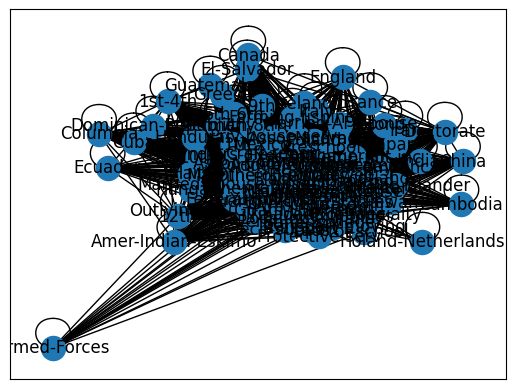

In [10]:
# Load the data and complete the data pre-processing
data_path = config_cat_embedding.paths['data']
data_path_out = config_cat_embedding.paths['data_output']
bank_data = pd.read_csv(data_path+'adult.csv', sep=',')

dat_bank, cat_cols = adult_data_prep(bank_data)

X = dat_bank.iloc[:, :-1]
target = dat_bank.y

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=1500)
X_train_cat = X_train[cat_cols]

co_occurrence_matrix_norm = create_cooccurrence_matrix_diag(X_train_cat)

categories = np.unique(X_train_cat)

# Build the graph
graph = nx.from_numpy_array(co_occurrence_matrix_norm.values)

# Set the layout for the visualization
pos = nx.spring_layout(graph)

# Draw the nodes and edges
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_edges(graph, pos)

# Add labels for the nodes
labels = {i: categories[i] for i in range(len(categories))}
nx.draw_networkx_labels(graph, pos, labels)

# Display the visualization
plt.show()



In [11]:
# Generate node2vec embeddings
node2vec = Node2Vec(graph, dimensions=30, walk_length=30, num_walks=10)
model = node2vec.fit(window=10, min_count=1)
model.save("node2vec.model.bank")

# Get the vocabulary
vocabulary = model.wv.index_to_key
#print("Vocabulary: ", vocabulary)

# Create a dictionary to map category to index
category_to_index = {cat: i for i, cat in enumerate(categories)}
category_to_index

cat2vec = {}
for i in range(len(categories)):
    cat2vec[categories[i]] = model.wv[model.wv.index_to_key[i]]
    
cat2vec

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.89it/s]


{'10th': array([ 0.00097725, -0.3409591 ,  0.44661224,  0.20425528, -0.14905168,
        -0.00975185,  0.10732561,  0.27848384, -0.32757083,  0.00669458,
         0.30212307,  0.2615125 , -0.12644613, -0.13473509, -0.16593187,
        -0.10743894,  0.29825485, -0.10431001, -0.18644422, -0.00393569,
         0.18199058, -0.1139017 , -0.08331069,  0.25172845,  0.20867917,
        -0.17124379,  0.543499  ,  0.27146012, -0.21247323, -0.24292752],
       dtype=float32),
 '11th': array([-0.339764  , -0.3369058 ,  0.33713078,  0.02901978, -0.27342978,
        -0.22426578,  0.34879807,  0.12448649, -0.34427184,  0.15255818,
         0.30885705,  0.31563303, -0.11030944,  0.1590221 , -0.24606001,
        -0.24588814, -0.18878607,  0.13540684, -0.16318105,  0.28507465,
        -0.01767006, -0.2898562 , -0.0958312 ,  0.18531871, -0.01635744,
        -0.09868965,  0.47058403,  0.08752189, -0.09578584, -0.18207772],
       dtype=float32),
 '12th': array([-0.02804731, -0.15770887,  0.35928765,  0.13

In [12]:
dimpool = 30
elements = []
for row in tqdm(X_train.iterrows()):
    categorical_embeddings = []
    for i in cat_cols:
        try:
            categorical_embeddings.append(cat2vec[row[1][i]])
        except:
            categorical_embeddings.append(np.zeros((dimpool)))
    elements.append(np.array(categorical_embeddings))
#elements 
reshaped_x = (np.reshape(elements,(len(elements),len(cat_cols)*dimpool)))   
# Get the numerical columns
numerical_cols = np.where(X_train.dtypes!="object")[0]
my_data = pd.concat([X_train.iloc[:, numerical_cols].reset_index(drop=True), pd.DataFrame(reshaped_x)], axis=1)
# due to the new index of my_data, we have to change the index of y_train
y_train = y_train.reset_index(drop=True)


C:\Users\P70071469\AppData\Local\Temp\ipykernel_22124\3506753142.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm(X_train.iterrows()):


0it [00:00, ?it/s]

In [16]:
np.shape(reshaped_x)

(36177, 240)

In [17]:
X.shape

(45222, 13)

In [18]:

#%% apply it on the X_test dataset 
elements_test = []
for row in tqdm(X_test.iterrows()):
    categorical_embeddings = []
    for i in cat_cols:
        #print(i,row[1][i])
        try:
            categorical_embeddings.append(cat2vec[row[1][i]])
        except:
            categorical_embeddings.append(np.zeros((dimpool)))
    elements_test .append(np.array(categorical_embeddings))

#elements 
reshaped_x_test = (np.reshape(elements_test ,(len(elements_test ),len(cat_cols)*dimpool)))   
# Get the numerical columns
my_test_data = pd.concat([X_test.iloc[:, numerical_cols].reset_index(drop=True), pd.DataFrame(reshaped_x_test)], axis=1)
# due to the new index of my_data, we have to change the index of y_train
y_test = y_test.reset_index(drop=True)

C:\Users\P70071469\AppData\Local\Temp\ipykernel_22124\2029421698.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm(X_test.iterrows()):


0it [00:00, ?it/s]

In [19]:
my_test_data.head(3)

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239
0,32,153588,0,0,40,-0.063990,-0.298594,-0.129782,0.162171,-0.156641,0.370059,0.804827,0.292165,-0.818765,0.094141,0.192468,0.411493,-0.014367,-0.125923,0.300463,-0.012195,0.327744,0.521209,-0.101185,0.393508,-0.236051,-0.190650,-0.590477,0.110087,-0.271581,0.142892,0.435929,-0.265933,-0.123486,0.059443,-0.199081,-0.208639,0.284449,0.106286,0.052192,0.092892,0.307187,0.319243,-0.369846,-0.270917,0.181433,0.126381,0.031057,0.174139,-0.181120,-0.004368,0.081864,0.029695,-0.125005,0.329806,0.137288,0.056059,-0.365842,0.46535,0.062197,0.065861,0.506436,0.016147,-0.291473,-0.471061,-0.111513,-0.021129,0.504625,0.084763,-0.063100,0.066789,0.226816,0.239493,-0.298885,0.046040,0.308998,0.180277,0.188189,-0.135448,-0.034715,-0.180490,0.210587,-0.182120,0.000915,0.161706,0.291494,-0.314226,-0.057736,0.382665,0.046224,0.026607,0.536157,0.139671,-0.270350,-0.227796,-0.176128,-0.152576,0.402098,0.004946,-0.205775,0.152889,0.311241,0.354510,-0.377067,0.131478,0.247986,0.184324,0.056058,-0.204214,0.054138,-0.196668,0.055275,-0.005476,-0.122569,0.210717,0.021196,-0.188258,-0.043141,0.336747,0.077444,0.183264,0.420072,0.021769,-0.243607,-0.236000,0.099566,-0.091004,0.186336,0.006936,0.131068,-0.287246,0.369959,0.190939,-0.418488,-0.445476,0.517063,-0.079317,0.215381,0.295705,-0.095092,0.136156,0.24517,0.358066,0.03448,0.236458,0.147667,-0.179187,-0.267795,0.608275,-0.188254,0.297166,0.461192,0.132685,-0.082304,-0.623054,0.073393,-0.148308,-0.265301,-0.567054,0.082415,-0.290091,0.585856,0.297383,-0.599376,0.098846,0.528446,-0.156033,-0.165829,0.197538,-0.838182,0.248059,0.09466,-0.162431,-0.033824,0.3998,-0.132172,-0.474925,0.767141,0.403591,-0.713355,0.519344,0.758146,-0.178119,-0.110252,-0.233838,-0.012079,-0.207196,0.375253,0.033008,-0.111318,0.037151,0.098346,0.343860,-0.273226,0.071692,0.330264,0.317229,-0.059002,-0.057168,-0.181095,0.044521,0.302098,-0.049912,-0.183535,0.021009,0.119437,-0.166756,-0.036911,0.362378,-0.115903,0.055663,0.525305,0.179827,-0.101319,-0.305782,0.107631,0.138283,0.566952,0.161691,0.590519,0.196585,0.662713,-0.228643,0.311351,0.411112,0.61908,-0.340898,-0.112317,-0.425883,-0.724303,-0.391587,0.751798,-0.190205,-0.684002,0.572923,-0.190265,0.415676,-0.198343,0.845804,-0.200511,-0.452876,0.112702,0.086674,-0.412944,-0.3534
1,56,225267,14084,0,60,-0.063990,-0.298594,-0.129782,0.162171,-0.156641,0.370059,0.804827,0.292165,-0.818765,0.094141,0.192468,0.411493,-0.014367,-0.125923,0.300463,-0.012195,0.327744,0.521209,-0.101185,0.393508,-0.236051,-0.190650,-0.590477,0.110087,-0.271581,0.142892,0.435929,-0.265933,-0.123486,0.059443,-0.093409,-0.023199,0.406238,-0.067401,-0.236680,0.564236,0.310065,0.388485,-0.369854,0.243603,-0.056869,-0.146280,-0.085541,-0.125079,-0.157173,-0.150607,0.117284,-0.210155,-0.335210,0.369843,-0.135131,-0.150361,-0.076640,0.59797,0.116051,0.190192,0.383343,-0.017755,-0.223003,-0.137498,-0.111513,-0.021129,0.504625,0.084763,-0.063100,0.066789,0.226816,0.239493,-0.298885,0.046040,0.308998,0.180277,0.188189,-0.135448,-0.034715,-0.180490,0.210587,-0.182120,0.000915,0.161706,0.291494,-0.314226,-0.057736,0.382665,0

In [20]:
import time
X_train2, X_test2, y_train2, y_test2 = train_test_split(my_data,y_train,test_size=0.2, random_state=1500)
stc = StandardScaler()
X_scaled = stc.fit_transform(X_train2.values)


In [21]:
X_train2.head(3)

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239
19999,19,91928,0,0,35,-0.06399,-0.298594,-0.129782,0.162171,-0.156641,0.370059,0.804827,0.292165,-0.818765,0.094141,0.192468,0.411493,-0.014367,-0.125923,0.300463,-0.012195,0.327744,0.521209,-0.101185,0.393508,-0.236051,-0.19065,-0.590477,0.110087,-0.271581,0.142892,0.435929,-0.265933,-0.123486,0.059443,-0.093409,-0.023199,0.406238,-0.067401,-0.236680,0.564236,0.310065,0.388485,-0.369854,0.243603,-0.056869,-0.146280,-0.085541,-0.125079,-0.157173,-0.150607,0.117284,-0.210155,-0.335210,0.369843,-0.135131,-0.150361,-0.076640,0.597970,0.116051,0.190192,0.383343,-0.017755,-0.223003,-0.137498,-0.178460,-0.379757,0.217954,-0.118635,-0.159592,-0.253069,0.320408,0.189412,-0.296653,0.089942,0.307971,0.402724,0.145555,-0.163710,-0.317949,-0.065800,0.051781,0.166864,-0.190304,0.182028,-0.016585,-0.247426,-0.120706,0.183590,-0.048159,0.043180,0.529338,0.043475,0.034167,-0.109085,0.096811,-0.373736,0.056738,0.025080,-0.139803,-0.293616,0.324745,0.094119,-0.386003,0.159390,0.339464,0.204376,0.251734,0.042107,-0.615873,0.066171,0.177275,0.079795,0.100547,0.126805,0.144082,-0.434278,0.090457,0.270119,0.188996,0.139421,0.781980,0.036280,-0.026886,-0.031893,0.187580,0.002364,0.324470,-0.082934,-0.187423,0.160577,0.451007,0.024324,0.195196,0.087352,0.207194,0.214008,-0.281991,-0.489964,-0.242401,0.054512,-0.030086,-0.064687,-0.887419,0.113949,-0.233530,-0.291259,-0.141796,0.469028,-0.410824,-0.558618,0.611981,-0.319466,-0.417289,-0.225011,0.073393,-0.148308,-0.265301,-0.567054,0.082415,-0.290091,0.585856,0.297383,-0.599376,0.098846,0.528446,-0.156033,-0.165829,0.197538,-0.838182,0.248059,0.09466,-0.162431,-0.033824,0.3998,-0.132172,-0.474925,0.767141,0.403591,-0.713355,0.519344,0.758146,-0.178119,-0.110252,-0.233838,-0.165574,-0.274602,0.318015,-0.056372,-0.286130,0.026785,0.179501,0.458623,-0.240476,-0.064590,0.094259,0.484273,-0.150808,-0.131647,-0.032485,0.127793,0.221601,-0.100044,-0.244020,0.134213,0.046266,-0.165784,-0.071744,0.253602,-0.106493,0.068744,0.527321,0.183170,-0.191628,-0.330677,0.107631,0.138283,0.566952,0.161691,0.590519,0.196585,0.662713,-0.228643,0.311351,0.411112,0.61908,-0.340898,-0.112317,-0.425883,-0.724303,-0.391587,0.751798,-0.190205,-0.684002,0.572923,-0.190265,0.415676,-0.198343,0.845804,-0.200511,-0.452876,0.112702,0.086674,-0.412944,-0.3534
23132,31,147215,0,0,21,-0.06399,-0.298594,-0.129782,0.162171,-0.156641,0.370059,0.804827,0.292165,-0.818765,0.094141,0.192468,0.411493,-0.014367,-0.125923,0.300463,-0.012195,0.327744,0.521209,-0.101185,0.393508,-0.236051,-0.19065,-0.590477,0.110087,-0.271581,0.142892,0.435929,-0.265933,-0.123486,0.059443,-0.028047,-0.157709,0.359288,0.135556,-0.164651,0.232210,0.383800,0.206829,-0.454871,-0.044085,0.252298,0.095188,-0.020833,-0.188481,-0.028975,-0.027771,0.273743,0.070540,-0.171409,0.107570,-0.052529,-0.014793,-0.248805,0.461703,0.061577,0.089918,0.443995,-0.110035,-0.093342,-0.245793,-0.111513,-0.021129,0.504625,0.084763,-0.063100,0.066789,0.226816,0.239493,-0.298885,0.046040,0.308998,0.180277,0.188189,-0.135448,-0.034715,-0.180490,0.210587,-0.182120,0.000915,0.161706,0.291494,-0.314226,-0.05

In [ ]:
# Also standardize the test data (my_test_data)
X_test_final_scaled = stc.transform(my_test_data.values)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import random
# Set the random seed for reproducibility
import time

random.seed(42)
np.random.seed(42)

# Define number of runs for cross-validation
n_runs = 5
kf = StratifiedKFold(n_splits=n_runs, shuffle=True, random_state=seed)
seed=42
# Initialize list to store results
results = []


models = [
    ('LR', LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=seed)),
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed, min_samples_leaf=3)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('XGB', XGBClassifier(eval_metric='logloss')),
    ('MLP', KerasClassifier(build_fn=create_network, number_of_features=my_data.shape[1], epochs=100, batch_size=100, verbose=0)),
    ('SVM', SVC(gamma='scale', random_state=seed, probability=True))
    
]

# Define number of runs for cross-validation
n_runs = 5
kf = StratifiedKFold(n_splits=n_runs, shuffle=True, random_state=42)

# Initialize list to store results
results = []

# Loop over the models
for name, model in models:
    print(f"Classifier: {name}")

    # Lists to store metrics for each fold
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    computation_times = []

    # Perform cross-validation
    for train_idx, val_idx in kf.split(X_scaled, y_train2):
        # Clone the model to ensure fresh training for each fold
        if name == 'MLP':
            # For KerasClassifier, re-instantiate to reset weights
            clf = KerasClassifier(build_fn=lambda: create_network(X_scaled.shape[1]),
                                  epochs=100, batch_size=100, verbose=0, random_state=seed)
        else:
            clf = clone(model)

        X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
        y_train_fold, y_val_fold = y_train2.iloc[train_idx], y_train2.iloc[val_idx]

        start_time = time.time()  # Start time

        clf.fit(X_train_fold, y_train_fold)
        y_pred = clf.predict(X_val_fold)

        # Handle probability predictions
        if hasattr(clf, "predict_proba"):
            y_pred_prob = clf.predict_proba(X_val_fold)[:, 1]
        elif hasattr(clf, "decision_function"):
            # For classifiers like SVM
            y_scores = clf.decision_function(X_val_fold)
            # Convert scores to probabilities using a sigmoid function
            from scipy.special import expit
            y_pred_prob = expit(y_scores)
        else:
            # If probability estimates are not available, use binary predictions
            y_pred_prob = y_pred

        end_time = time.time()  # End time
        computation_time = end_time - start_time  # Computation time

        # Append metrics for this fold
        accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
        precision_scores.append(precision_score(y_val_fold, y_pred, zero_division=0))
        recall_scores.append(recall_score(y_val_fold, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_val_fold, y_pred, zero_division=0))
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred_prob))
        computation_times.append(computation_time)

    # Compute mean and standard deviation of all metrics
    mean_accuracy = np.mean(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)

    mean_precision = np.mean(precision_scores)
    std_precision = np.std(precision_scores)

    mean_recall = np.mean(recall_scores)
    std_recall = np.std(recall_scores)

    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)

    mean_roc_auc = np.mean(roc_auc_scores)
    std_roc_auc = np.std(roc_auc_scores)

    mean_time = np.mean(computation_times)
    std_time = np.std(computation_times)

    # Store results for the current model
    results.append({
        "Classifier": name,
        "Mean Accuracy": mean_accuracy, "STD Accuracy": std_accuracy,
        "Mean Precision": mean_precision, "STD Precision": std_precision,
        "Mean Recall": mean_recall, "STD Recall": std_recall,
        "Mean F1 Score": mean_f1, "STD F1 Score": std_f1,
        "Mean ROC AUC": mean_roc_auc, "STD ROC AUC": std_roc_auc,
        "Mean Computation Time": mean_time, "STD Computation Time": std_time
    })

    # Print results
    print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
    print(f"Mean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")
    print(f"Mean Computation Time: {mean_time:.4f} ± {std_time:.4f} seconds")
    print()

# Create a DataFrame to display all results
results_df = pd.DataFrame(results)
print(results_df)
X_test_scaled = stc.transform(X_test2.values)
X_test_final_scaled = stc.transform(my_test_data.values)

# Also standardize the test data (my_test_data)
X_test_final_scaled = stc.transform(my_test_data.values)
# Final evaluation on the validation set (X_test2, y_test2)
print("Evaluation on validation set (X_test2, y_test2):")
for name, model in models:
    print(f"Final Evaluation for Classifier: {name}")
    start_time = time.time()
    if name == 'MLP':
        model = KerasClassifier(build_fn=lambda: create_network(X_scaled.shape[1]),
                                epochs=100, batch_size=100, verbose=0, random_state=seed)
    else:
        model = clone(model)
    model.fit(X_scaled, y_train2)
    end_time = time.time()
    computation_time = end_time - start_time

    y_pred_test = model.predict(X_test_scaled)

    if hasattr(model, "predict_proba"):
        y_pred_prob_test = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test_scaled)
        from scipy.special import expit
        y_pred_prob_test = expit(y_scores)
    else:
        y_pred_prob_test = y_pred_test

    print(confusion_matrix(y_test2, y_pred_test))
    print(classification_report(y_test2, y_pred_test, digits=4))
    print(f"ROC AUC Score: {roc_auc_score(y_test2, y_pred_prob_test):.4f}")
    print(f"Computation Time: {computation_time:.4f} seconds")
    print()

# Final evaluation on the test set (my_test_data, y_test)
print("Evaluation on test set (my_test_data, y_test):")
for name, model in models:
    print(f"Final Evaluation for Classifier: {name}")
    start_time = time.time()
    if name == 'MLP':
        model = KerasClassifier(build_fn=lambda: create_network(X_scaled.shape[1]),
                                epochs=100, batch_size=100, verbose=0, random_state=seed)
    else:
        model = clone(model)
    # Combine X_scaled and X_test_scaled for final training
    X_combined = np.vstack((X_scaled, X_test_scaled))
    y_combined = pd.concat([y_train2.reset_index(drop=True), y_test2.reset_index(drop=True)], ignore_index=True)
    model.fit(X_combined, y_combined)
    end_time = time.time()
    computation_time = end_time - start_time

    y_pred_test = model.predict(X_test_final_scaled)

    if hasattr(model, "predict_proba"):
        y_pred_prob_test = model.predict_proba(X_test_final_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test_final_scaled)
        from scipy.special import expit
        y_pred_prob_test = expit(y_scores)
    else:
        y_pred_prob_test = y_pred_test

    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test, digits=4))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_test):.4f}")
    print(f"Computation Time: {computation_time:.4f} seconds")
    print()



Classifier: LR
Mean Accuracy: 0.8509 ± 0.0034
Mean Precision: 0.7389 ± 0.0100
Mean Recall: 0.6157 ± 0.0070
Mean F1 Score: 0.6717 ± 0.0070
Mean ROC AUC: 0.9056 ± 0.0050
Mean Computation Time: 1.1782 ± 0.0745 seconds

Classifier: DT
Mean Accuracy: 0.8373 ± 0.0037
Mean Precision: 0.7723 ± 0.0146
Mean Recall: 0.4867 ± 0.0050
Mean F1 Score: 0.5971 ± 0.0080
Mean ROC AUC: 0.8592 ± 0.0033
Mean Computation Time: 0.3087 ± 0.0050 seconds

Classifier: MLP


C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\keras\src\layers\core\dense.py:87

Mean Accuracy: 0.8349 ± 0.0050
Mean Precision: 0.6996 ± 0.0310
Mean Recall: 0.5899 ± 0.0342
Mean F1 Score: 0.6386 ± 0.0103
Mean ROC AUC: 0.8832 ± 0.0087
Mean Computation Time: 31.3330 ± 5.7525 seconds

  Classifier  Mean Accuracy  STD Accuracy  Mean Precision  STD Precision  \
0         LR       0.850938      0.003399        0.738916       0.010026   
1         DT       0.837324      0.003732        0.772328       0.014577   
2        MLP       0.834871      0.004961        0.699627       0.031037   

   Mean Recall  STD Recall  Mean F1 Score  STD F1 Score  Mean ROC AUC  \
0     0.615737    0.007035       0.671694      0.006960      0.905596   
1     0.486674    0.004991       0.597080      0.007959      0.859215   
2     0.589932    0.034207       0.638570      0.010310      0.883205   

   STD ROC AUC  Mean Computation Time  STD Computation Time  
0     0.004966               1.178222              0.074512  
1     0.003252               0.308726              0.004981  
2     0.008666

C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[[4913  509]
 [ 694 1120]]
              precision    recall  f1-score   support

           0     0.8762    0.9061    0.8909      5422
           1     0.6875    0.6174    0.6506      1814

    accuracy                         0.8337      7236
   macro avg     0.7819    0.7618    0.7708      7236
weighted avg     0.8289    0.8337    0.8307      7236

ROC AUC Score: 0.8878
Computation Time: 37.2473 seconds

Evaluation on test set (my_test_data, y_test):
Final Evaluation for Classifier: LR
[[6283  535]
 [ 893 1334]]
              precision    recall  f1-score   support

           0     0.8756    0.9215    0.8980      6818
           1     0.7138    0.5990    0.6514      2227

    accuracy                         0.8421      9045
   macro avg     0.7947    0.7603    0.7747      9045
weighted avg     0.8357    0.8421    0.8372      9045

ROC AUC Score: 0.8995
Computation Time: 1.9372 seconds

Final Evaluation for Classifier: DT
[[6470  348]
 [1138 1089]]
              precision    recall

C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[[6099  719]
 [ 744 1483]]
              precision    recall  f1-score   support

           0     0.8913    0.8945    0.8929      6818
           1     0.6735    0.6659    0.6697      2227

    accuracy                         0.8383      9045
   macro avg     0.7824    0.7802    0.7813      9045
weighted avg     0.8377    0.8383    0.8379      9045

ROC AUC Score: 0.8896
Computation Time: 45.8393 seconds



In [31]:
seed=42
models = [
    ('LR', LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=seed)),
    #    3('RF', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed, min_samples_leaf=3)),
    #('KNN', KNeighborsClassifier(n_neighbors=3)),
    #('XGB', XGBClassifier(eval_metric='logloss')),
   # ('SVM', SVC(gamma='scale', random_state=seed, probability=True)),
    ('MLP', KerasClassifier(build_fn=create_network, number_of_features=my_data.shape[1], epochs=100, batch_size=100, verbose=0))
]

for name, classifier in models:
    start_time = time.time()
    classifier.fit(X_scaled, y_train2)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Classifier: {name}")
    print(f"Computation Time: {elapsed_time} seconds")      
#     y_pred = classifier.predict(stc.transform(X_test2.values))
#     y_pred_prob = classifier.predict_proba(stc.transform(X_test2.values))

#     print(confusion_matrix(y_test2,y_pred))
#     print(classification_report(y_test2,y_pred, digits=4))
#     print(roc_auc_score(y_test2,y_pred_prob[:,1]))
    
    y_pred_test = classifier.predict(stc.transform(my_test_data.values))
    y_pred_prob_test = classifier.predict_proba(stc.transform(my_test_data.values))

    print(confusion_matrix(y_test,y_pred_test))
    print(classification_report(y_test,y_pred_test, digits=4))

    print(roc_auc_score(y_test,y_pred_prob_test[:,1]))
    print()
  # Define number of runs for cross-validation


Classifier: LR
Computation Time: 2.609105348587036 seconds
[[6281  537]
 [ 894 1333]]
              precision    recall  f1-score   support

           0     0.8754    0.9212    0.8977      6818
           1     0.7128    0.5986    0.6507      2227

    accuracy                         0.8418      9045
   macro avg     0.7941    0.7599    0.7742      9045
weighted avg     0.8354    0.8418    0.8369      9045

0.899425277893655

Classifier: DT
Computation Time: 0.4590764045715332 seconds
[[6470  348]
 [1138 1089]]
              precision    recall  f1-score   support

           0     0.8504    0.9490    0.8970      6818
           1     0.7578    0.4890    0.5944      2227

    accuracy                         0.8357      9045
   macro avg     0.8041    0.7190    0.7457      9045
weighted avg     0.8276    0.8357    0.8225      9045

0.8521044889890373

Classifier: RF
Computation Time: 8.663427829742432 seconds
[[6407  411]
 [1104 1123]]
              precision    recall  f1-score   su

C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Classifier: MLP
Computation Time: 39.61129379272461 seconds
[[6086  732]
 [ 802 1425]]
              precision    recall  f1-score   support

           0     0.8836    0.8926    0.8881      6818
           1     0.6606    0.6399    0.6501      2227

    accuracy                         0.8304      9045
   macro avg     0.7721    0.7663    0.7691      9045
weighted avg     0.8287    0.8304    0.8295      9045

0.881198544279696

